# GradInit

In [ ]:
try:
    import netket as nk
except ImportError:
    !pip install --quiet --upgrade netket
    import netket as nk

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
from netket.operator.spin import sigmax,sigmaz 
from scipy.sparse.linalg import eigsh
from netket.utils.types import NNInitFunc
from typing import Any

# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np

print(f"NetKet version: {nk.__version__}")
jnp.set_printoptions(precision=5)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.2/720.2 kB 14.1 MB/s eta 0:00:00
NetKet version: 3.8


In [ ]:
N = 20

hi = nk.hilbert.Spin(s=1/2, N=N)
# hi.random_state(jax.random.PRNGKey(0),3)

In [ ]:
Gamma = -1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])
V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

In [ ]:
sp_h=H.to_sparse()
print(sp_h.shape)

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

(1048576, 1048576)
eigenvalues with scipy sparse: [-25.49099 -25.41241]


# Модели

In [ ]:
# Place for model

# Теорема Цыбенко. Исходя из нее и можно сделать простенькую модель  
# https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%A6%D1%8B%D0%B1%D0%B5%D0%BD%D0%BA%D0%BE
default_kernel_init = nn.initializers.normal(stddev=0.01)

class VanilaForGradInitModel(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    alpha : int = 1
    activation: Any = nk.nn.tanh # nk.nn.log_cosh
    kernel_init: NNInitFunc = default_kernel_init
    bias_init: NNInitFunc = default_kernel_init
    
    @nn.compact
    def __call__(self, x):
        in_sz = x.shape[-1]
        out_sz = in_sz * self.alpha

        alpha_1 = self.param(
            "alpha_1", nn.initializers.constant(1), (1,), float
        )
        
        skew_W_1 = self.param('skew_W_1',
                        nn.initializers.constant(0), # Initialization function
                        (in_sz, out_sz, ), float)  # shape info.
                        
        skew_bias_1 = self.param("skew_bias_1", 
                            nn.initializers.constant(0),
                            (out_sz,), float)

        alpha_2 = self.param(
            "alpha_2", nn.initializers.constant(1), (1,), float
        )        

        skew_W_2 = self.param('skew_W_2',
                        nn.initializers.normal(0), # Initialization function
                        (out_sz, 1, ), float)  # shape info.


        # use kaiming_normal as in original gradInit
        # other variants: https://flax.readthedocs.io/en/latest/api_reference/flax.linen.html#module-flax.linen.initializers
        # first_layer = nn.Dense(features=self.alpha * x.shape[-1], use_bias=True,
        #                        kernel_init=self.kernel_init, 
        #                        bias_init=self.bias_init)


        # nn.initializers.kaiming_normal() 

        # or standart to flax Dense layer nn.initializers.lecun_normal()
        # https://github.com/google/flax/blob/main/flax/linen/linear.py#L44
        W_1 = self.param('W_1', self.kernel_init,
                        (in_sz, out_sz, ), float)  # shape info.
       
        bias_1 = self.param("bias_1", self.bias_init,
                            (out_sz,), float)
        
        W_2 = self.param('W_2', self.kernel_init,
                        (out_sz, 1, ), float)
                          
        y = jnp.dot(x, alpha_1 * W_1  - skew_W_1) + alpha_1 * bias_1 - skew_bias_1

        y = self.activation(y)

        y = jnp.dot(y, alpha_2 * W_2  - skew_W_2)
        
        # sum the output
        # return nn.tanh(jnp.sum(y, axis=-1)) # pretty good results
        return jnp.sum(y, axis=-1)

class VanilaModel(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module.
    alpha : int = 1
    activation: Any = nk.nn.tanh
    kernel_init: NNInitFunc = default_kernel_init
    bias_init: NNInitFunc = default_kernel_init
    
    @nn.compact
    def __call__(self, x):
        in_sz = x.shape[-1]
        out_sz = in_sz * self.alpha

        W_1 = self.param('W_1', self.kernel_init,
                        (in_sz, out_sz, ), float)  # shape info.
       
        bias_1 = self.param("bias_1", self.bias_init,
                            (out_sz,), float)
        
        W_2 = self.param('W_2', self.kernel_init,
                        (out_sz, 1, ), float)
                          
        y = jnp.dot(x, W_1) + bias_1

        y = self.activation(y)

        # y = jnp.dot(y, W_2)
        
        # sum the output
        # return nn.tanh(jnp.sum(y, axis=-1)) # pretty good results
        return jnp.sum(y, axis=-1)        
    
# FFN == VanilaModel in unicorn world!
class FFN(nn.Module):
    
    alpha : int = 1
    activation: Any = nk.nn.tanh # nk.nn.log_cosh

    @nn.compact
    def __call__(self, x):

        # It's possible to set init funcs
        dense_1 = nn.Dense(features=self.alpha * x.shape[-1]) 
        dense_2 = nn.Dense(features=1, use_bias=False) 
        y = dense_1(x)
        y = dense_2(self.activation(y))
        return jnp.sum(y, axis=-1)    

g_norm_pa = lambda e_grad, algo: jnp.linalg.norm(
                                        jnp.concatenate([e_grad['W_1'].flatten(), 
                                                         e_grad['W_2'].flatten(), 
                                                         e_grad['bias_1']]), 
                                        ord = 1 if algo == 'adam' else 2)

# GradInitRBM

In [ ]:
default_kernel_init = nn.initializers.normal(stddev=0.01)

# RBM replica
class GradInitRBM(nn.Module):
   
    alpha : int = 1
    kernel_init: NNInitFunc = default_kernel_init
    bias_init: NNInitFunc = default_kernel_init
    activation: Any = nk.nn.log_cosh

    """feature density. Number of features equal to alpha * input.shape[-1]"""
    @nn.compact
    def __call__(self, input):
        in_sz = input.shape[-1]
        out_sz = in_sz * self.alpha

        alpha_1 = self.param(
            "alpha_1", nn.initializers.constant(1), (1,), float
        )

        skew_W_1 = self.param('skew_W_1',
                        nn.initializers.constant(0), # Initialization function
                        (in_sz, out_sz,), float)  # shape info.
                        
        skew_h_bias = self.param("skew_h_bias", 
                            nn.initializers.constant(0),
                            (out_sz,), float)    
                    
        skew_v_bias = self.param("skew_v_bias", 
                            nn.initializers.constant(0),
                            (in_sz,), float)
        
        
        # real matrices
        W_1 = self.param('W_1', self.kernel_init, 
                        (in_sz, out_sz,), float)
        
        
        # hidden bias
        h_bias = self.param("h_bias", self.bias_init, 
                            (out_sz,), float)
        
        # visible bias
        v_bias = self.param("v_bias", self.bias_init, 
                            (in_sz,), float)
        
        x = jnp.dot(input, alpha_1 * W_1 - skew_W_1) + alpha_1 * h_bias - skew_h_bias
        x = self.activation(x)
        x = jnp.sum(x, axis=-1)

        out_bias = jnp.dot(input, v_bias - skew_v_bias)
        return x + out_bias

# RBM replica
class GradInitSymmRBM(nn.Module):
   
    alpha : int = 1
    kernel_init: NNInitFunc = default_kernel_init
    bias_init: NNInitFunc = default_kernel_init
    activation: Any = nk.nn.log_cosh

    """feature density. Number of features equal to alpha * input.shape[-1]"""
    @nn.compact
    def __call__(self, input):
        in_sz = input.shape[-1]
        out_sz = in_sz * self.alpha

        sigma_W = self.param(
            "sigma_W", nn.initializers.constant(1), (1,), float
        )

        sigma_h = self.param(
            "sigma_h", nn.initializers.constant(1), (1,), float
        )

        sigma_v = self.param(
            "sigma_v", nn.initializers.constant(1), (1,), float
        )

        mu_W = self.param(
            "mu_W", nn.initializers.constant(0), (1,), float
        )
        
        mu_h = self.param(
            "mu_h", nn.initializers.constant(0), (1,), float
        )

        mu_v = self.param(
            "mu_v", nn.initializers.constant(0), (1,), float
        )
        
        skew_W_1 = self.param('skew_W_1',
                        nn.initializers.constant(0), # Initialization function
                        (in_sz, out_sz,), float)  # shape info.
                        
        skew_h_bias = self.param("skew_h_bias", 
                            nn.initializers.constant(0),
                            (out_sz,), float)    
                    
        skew_v_bias = self.param("skew_v_bias", 
                            nn.initializers.constant(0),
                            (out_sz,), float)
        
        
        # real matrices
        W_1 = self.param('W_1', self.kernel_init, 
                        (in_sz, out_sz,), float)
        
        
        # hidden bias
        h_bias = self.param("h_bias", self.bias_init, 
                            (out_sz,), float)
        
        # visible bias
        v_bias = self.param("v_bias", self.bias_init, 
                            (out_sz,), float)
        
        x = jnp.dot(input, sigma_W * W_1 + mu_W - skew_W_1) + alpha_1 * h_bias + mu_h - skew_h_bias
        x = self.activation(x)
        x = jnp.sum(x, axis=-1)

        out_bias = jnp.dot(input, v_bias - skew_v_bias)
        return x + out_bias

g_norm_pa = lambda e_grad, algo: jnp.linalg.norm(
                                        jnp.concatenate([e_grad['W_1'].flatten(), 
                                                         e_grad['h_bias'],
                                                         e_grad['v_bias']]), 
                                        ord = 1 if algo == 'adam' else 2)

# GradInit impl

In [ ]:
A_gt = lambda e_grad, gamma, algo: jax.tree_map(
    lambda x: jnp.sign(x), e_grad) if algo == "adam" else jax.tree_map(
        lambda x: gamma * x / g_norm_pa(e_grad, "sgd"), e_grad) 
    
def print_info(i, n_steps, gamma, init_g_norm,  g_grad, init_alphas, alpha_grad, new_pars, tau_a, tau_g):
    if (i % max(n_steps//10, 1)) == 0 or i == n_steps:
        if init_g_norm < gamma:
            print('#', i, 'g_norm < gamma: \n\tg_norm=', init_g_norm, 
                ': alpha_grad= (', *alpha_grad['alpha_1'], '), tau_a=', tau_a)
        else:   
             print('#', i, 'g_norm > gamma: \n\tg_norm=', init_g_norm , 
                ', g_grad= (', g_grad['alpha_1'],'), tau_g=', tau_g)
             
        print('\tfrom init alphas (', *init_alphas['alpha_1'], ')', 
              ' to (', *new_pars['alpha_1'], ')', 
              '\n\tcur energy = ', vstate.expect(H).mean, '\n')

In [ ]:
N = 20

hi = nk.hilbert.Spin(s=1/2, N=N)

Gamma = -1
H = sum([Gamma*sigmax(hi,i) for i in range(N)])
V=-1
H += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

sp_h=H.to_sparse()
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
E_gs = eig_vals[0]


plot_data = {}

In [ ]:
N_chains = 16
N_samples = 1024

print(E_gs)
# print(vstate.samples.shape)

-25.490989686364866


In [ ]:
smplr_seed = jax.random.PRNGKey(10)
st_seed = jax.random.PRNGKey(7)
hi_seed = jax.random.PRNGKey(12)
# hi_seed = jax.random.PRNGKey()

hi.random_state(hi_seed, N)
sampler = nk.sampler.MetropolisLocal(hi, n_chains=N_chains)

In [ ]:
model = nk.models.RBM(alpha=1)
vstate = nk.vqs.MCState(sampler, model, n_samples=N_samples, seed=st_seed, sampler_seed=smplr_seed)

In [ ]:
E, E_grad = vstate.expect_and_grad(H)
print(E)
print(g_norm_pa(E_grad, algo='adam'))

# GradInit impl

In [ ]:
model = GradInitRBM(alpha=2, bias_init= nn.initializers.normal(1), 
                             kernel_init= nn.initializers.normal(1))

vstate = nk.vqs.MCState(sampler, model, n_samples=N_samples) #, seed=st_seed, sampler_seed=smplr_seed)
# my_adam = AdamOptim()

In [ ]:
E, E_grad = vstate.expect_and_grad(H)
print(E)
print(g_norm_pa(E_grad, algo='sgd'))

-2.76 ± 0.16 [σ²=16.05, R̂=1.2605]
87.8924438189391


In [ ]:
# article "tau" was in range between 10^-3 and 10^-1 

alpha_lower = jnp.array(1e-2, dtype=float)
m_delta = alpha_lower / 100

# Sgd: 
# 1. A[g_s] = gamma * g_s/ ||g_s||_2
# 2. eta * gamma^2 = change_in_loss = 0.1
# 3. p_a = l2

algo_name = 'sgd'
gamma = 10**jnp.floor(jnp.log10((g_norm_pa(E_grad, algo='sgd'))))  # 10 # upper_grad_bound
print('gamma=', gamma)
change_in_loss = 5
eta = 0.1 # change_in_loss / (gamma * gamma)

tau_g = 1 / (gamma * 10)
tau_a = min(tau_g * 10, 0.1)


# Adam:
# 1. A[g_s] = sign[g_s]
# 2. eta * gamma = change_in_loss = 0.1
# 3. p_a = l1 (huge grad values)

# algo_name = 'adam'

# gamma = 100 # upper_grad_bound

# change_in_loss = 0.1
# eta = change_in_loss / gamma
# tau_g = 1 / (gamma * 10)
# tau_a = tau_g * 100

gamma= 10.0


In [ ]:
# VMC driver sources: https://github.com/netket/netket/blob/4ac191ca9749930278881297e068f57457a2e9cb/netket/driver/vmc.py#L121
n_steps = 10
energy_history = []

tuple_of_alphas = ('alpha_1',)
tuple_of_skews =  ('skew_W_1', 'skew_h_bias', 'skew_v_bias') # ('skew_W_1', 'skew_bias_1', 'skew_W_2')

alpha_grad = {name : None for name in tuple_of_alphas}
g_grad = {name : None for name in tuple_of_alphas}
adam_dicts = {name : {'m': 0, 'v': 0} for name in tuple_of_alphas}


# For every iteration (tqdm is just a progress bar)
# for i in tqdm(range(n_steps)):
for i in range(n_steps):
    
    # compute energy and gradient of the energy
    E, E_grad = vstate.expect_and_grad(H)
    # log the energy to a list
    energy_history.append(E.mean.real)
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    init_g_norm = g_norm_pa(E_grad, algo_name)
    init_alphas = {name : vstate.parameters[name] for name in tuple_of_alphas}
    
    if init_g_norm > gamma:
        
        for cur_alpha in tuple_of_alphas:
            new_pars = flax.core.unfreeze(vstate.parameters)
            new_pars[cur_alpha] += m_delta
            vstate._parameters = new_pars
            E_grad = vstate.grad(H)

            g_norm_plus_delta = g_norm_pa(E_grad, algo_name)
            g_grad[cur_alpha] = (g_norm_plus_delta - init_g_norm) / m_delta

            new_pars[cur_alpha] -= m_delta
            vstate._parameters = new_pars

        for cur_alpha in tuple_of_alphas:
            # print(my_adam.update(tau_a, i, cur_alpha, new_pars, adam_dicts, g_grad))
            # new_pars[cur_alpha], adam_dicts[cur_alpha]['m'], adam_dicts[cur_alpha]['v'] = \
            #         my_adam.update(tau_g, i, cur_alpha, new_pars, adam_dicts, g_grad)
            new_pars[cur_alpha] -= tau_g * g_grad[cur_alpha]

    else:
        vstate.sample()
        new_pars = flax.core.unfreeze(vstate.parameters)
        A_gt_cur = A_gt(E_grad, gamma, algo_name)
        for name in tuple_of_skews:
            new_pars[name] = eta * A_gt_cur[name]
        
        vstate._parameters = new_pars # new samples here if not _parameters

        whole_grad = vstate.grad(H)
        alpha_grad = {name : whole_grad[name] for name in tuple_of_alphas}
        new_pars = flax.core.unfreeze(vstate.parameters)

        for name in tuple_of_skews:
            new_pars[name] *= 0  

        for cur_alpha in tuple_of_alphas:
            # print(my_adam.update(tau_a, i, cur_alpha, new_pars, adam_dicts, alpha_grad))
            # new_pars[cur_alpha], adam_dicts[cur_alpha]['m'], adam_dicts[cur_alpha]['v'] = \
            #         # my_adam.update(tau_a, i, cur_alpha, new_pars, adam_dicts, alpha_grad)
            new_pars[cur_alpha] -= tau_a * alpha_grad[cur_alpha]

        # print(*alpha_grad['alpha_1'])
        # vstate._parameters = new_pars
        
    for cur_alpha in tuple_of_alphas: 
        new_pars[cur_alpha] = jnp.maximum(new_pars[cur_alpha], alpha_lower)

    print_info(i, n_steps, gamma, init_g_norm, g_grad, init_alphas, alpha_grad, new_pars, tau_a, tau_g)
        
    # actually update the paramters
    vstate.parameters = new_pars
    
    #vstate.sample()

# print(vstate.parameters)
gradInitVstate = vstate

# После gradInit

In [ ]:
N_iters=20

Optimized energy : -16.692 ± 0.017 [σ²=0.292, R̂=1.0098]
relative error   : 0.3451664810126654


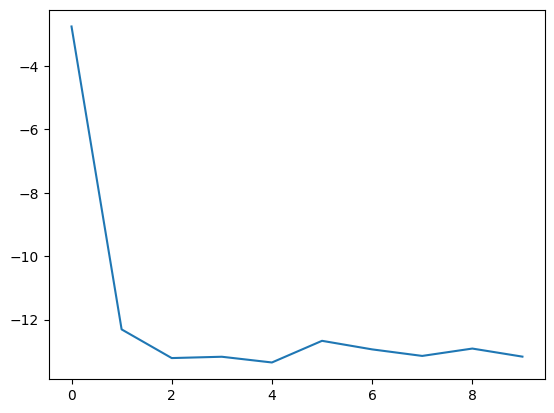

In [ ]:
res_energy=vstate.expect(H)
error=abs((res_energy.mean-E_gs)/E_gs)
print(f"Optimized energy : {res_energy}")
print(f"relative error   : {error}")

plt.plot(energy_history)

In [ ]:
# Apply GradInit Results
model, model_name = nk.models.RBM(alpha=2), 'RBM_AfterGradInit'
vstate = nk.vqs.MCState(sampler, model, n_samples=N_samples, seed=st_seed, sampler_seed=smplr_seed)

alpha_1 = gradInitVstate.parameters['alpha_1']
new_pars = flax.core.unfreeze(vstate.parameters)
new_pars["Dense"]["kernel"] = gradInitVstate.parameters['W_1'] * alpha_1
new_pars["Dense"]["bias"] = gradInitVstate.parameters['h_bias'] * alpha_1
new_pars["visible_bias"] = gradInitVstate.parameters['v_bias'] * alpha_1
vstate.parameters = new_pars

In [ ]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05) # much worse for default lr=0.01, Adam performs better for FFN
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1))

N_iters=100


log=nk.logging.RuntimeLog()
gs.run(n_iter=N_iters, out=log)

res_energy=vstate.expect(H)
print(f"Target energy: {E_gs}")
print(f"Optimized energy: {res_energy}")

error=abs((res_energy.mean-E_gs)/E_gs)
print(f"relative error   : {error * 100:.2f}%")
plot_data[model_name] = log.data

Text(0, 0.5, 'Energy')

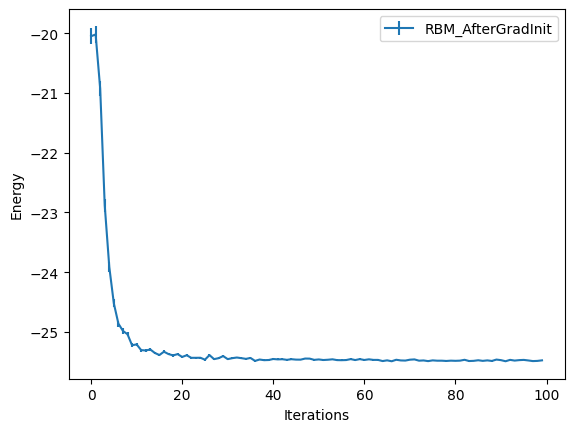

In [ ]:
plot_data[model_name] = log.data
cur_name = model_name # 'FFN' #
plt.errorbar(plot_data[cur_name]["Energy"].iters, plot_data[cur_name]["Energy"].Mean, 
             yerr=plot_data[cur_name]["Energy"].Sigma, label=cur_name)
# plt.hlines([E_gs], xmin=0, xmax=N_iters, color='black', label="Exact")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Energy')

# Other models

In [ ]:
N_iters=100

# smplr_seed = jax.random.PRNGKey(1)
# st_seed = jax.random.PRNGKey(70)
# hi_seed = jax.random.PRNGKey(120)

# hi.random_state(hi_seed, N)

init_model = nk.models.RBM(alpha=4, 
                           kernel_init= nn.initializers.normal(0.3),
                           visible_bias_init= nn.initializers.normal(0.03), 
                           hidden_bias_init= nn.initializers.normal(0.3))

for model, model_name in ((init_model, 'RBM'),): 
    sampler = nk.sampler.MetropolisLocal(hi, n_chains=N_chains)
    vstate = nk.vqs.MCState(sampler, model)

    optimizer = nk.optimizer.Sgd(learning_rate=0.05) 
    gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=nk.optimizer.SR(diag_shift=0.1) if 'noSR' not in model_name else None)

    log=nk.logging.RuntimeLog()

    gs.run(n_iter=N_iters, out=log)

    res_energy=vstate.expect(H)
    print(model_name)
    print(f"Target energy: {E_gs}")
    print(f"Optimized energy: {res_energy}")

    error=abs((res_energy.mean-E_gs)/E_gs)
    print(f"relative error   : {error * 100:.2f}%\n")
    plot_data[model_name] = log.data

100%|██████████| 100/100 [00:33<00:00,  3.01it/s, Energy=-18.090 ± 0.017 [σ²=0.287, R̂=1.0047]]


RBM
Target energy: -25.490989686364866
Optimized energy: -18.106 ± 0.021 [σ²=0.428, R̂=1.0123]
relative error   : 28.97%



In [ ]:
print('h_bias: mu=', jnp.mean(vstate.parameters['Dense']['bias']), ', sigma=', jnp.std(vstate.parameters['Dense']['bias']))
print('kernel: mu=', jnp.mean(vstate.parameters['Dense']['kernel']), ', sigma=', jnp.std(vstate.parameters['Dense']['kernel']))
print('v_bias: mu=', jnp.mean(vstate.parameters['visible_bias']), ', sigma=', jnp.std(vstate.parameters['visible_bias']))

h_bias: mu= -0.053628486285357636 , sigma= 0.2727425014076577
kernel: mu= -0.0032187730471637966 , sigma= 0.26977447739291865
v_bias: mu= -0.003790594445688081 , sigma= 0.0726391347161403


In [ ]:
# del plot_data['RBM']

In [ ]:
# plt.plot(energy_history, label="GradInit" if len(energy_history) != 0 else None)
skip_iter = 0

for cur_name in ('VanilaModel', 'FFN', 'RBM', 'RBM_1', 'RBM_4', 'RBM_noSR', 'Jastrow', 'NDM', 'NDM_noSR', 'RBM_AfterGradInit', 'RBM_woGradInit'):
# for cur_name in ('RBM',):
    if cur_name in plot_data: 
        plt.errorbar(plot_data[cur_name]["Energy"].iters[skip_iter:], plot_data[cur_name]["Energy"].Mean[skip_iter:], 
                        yerr=plot_data[cur_name]["Energy"].Sigma[skip_iter:], label=cur_name)
plt.hlines([E_gs], xmin=skip_iter, xmax=N_iters, color='black', label="Exact")
plt.legend()

# N_to_plot = 20; plt.axis([0,N_to_plot,E_gs-0.3,E_gs+5])
plt.xlabel('Iterations')
plt.ylabel('Energy')